In [1]:
import saopaulo.sp_grid as gr
from bikescience.slope import plot_slope, plot_slopes, split_route

from math import floor, ceil
import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

#od_routes = pd.read_csv('../data/sao-paulo/od/routes.csv')
od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}

#od_routes_all = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_all.shp')
#od_routes_all.crs = {'init': 'epsg:4326'}

od_routes_sp['length'] = od_routes_sp['geometry'].length
#display(od_routes_sp.sort_values('length').tail(5))

route_stretchs_size = 500 #meters

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
plot_slope (fmap, od_routes_sp.iloc[881]['geometry'], route_stretchs_size)
display(fmap)

fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
plot_slope (fmap, od_routes_sp.iloc[881]['geometry'], route_stretchs_size, absolute=True)
display(fmap)

In [3]:
sizes = [5000, 1000, 500, 200, 100, 'line']
def show_slopes_widgets( routes, title = "Declividade das rotas de viagens de bicicleta da OD 2017"):
    # transform the lambda code in string, so we can pass as a string widget
    #pass the parameters as hidden widgets
    im = interact_manual(
        show_slopes,
        routes = fixed(routes),
        title = fixed(title),
        absolute = widgets.Checkbox(value=False, description = 'Valor absoluto'),
        size = widgets.Dropdown(options = sizes, value=500,
                                 description = 'Trechos (em metros)')
    )
    im.widget.children[2].description = 'Gerar o mapa'
    
def show_slopes(routes, title, absolute, size):
    fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
    folium.GeoJson(zone_shp.loc[zone_shp['NumeroMuni'] == 36],
                   style_function = lambda x: {'color': 'black', 'weight': 0.5, 'fillOpacity': 0},
                   name='Zonas', control=True).add_to(fmap)
    plot_slopes(fmap, routes, size, absolute, title)
    folium.LayerControl().add_to(fmap)
    file = 'maps/slopes_' + str(size) + '.html'
    fmap.save(file)
    display(HTML('Salvo em <a href="' + file + '" target="_blank">' + file + '</a>'))
    display(fmap)

In [4]:
show_slopes_widgets(od_routes_sp['geometry'])

interactive(children=(Checkbox(value=False, description='Valor absoluto'), Dropdown(description='Trechos (em m…

In [5]:
show_slopes_widgets(od_routes_sp['geometry'])

interactive(children=(Checkbox(value=False, description='Valor absoluto'), Dropdown(description='Trechos (em m…

In [6]:
fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
plot_slope (fmap, od_routes_sp.iloc[211]['geometry'], 'line', absolute=False)
display(fmap)

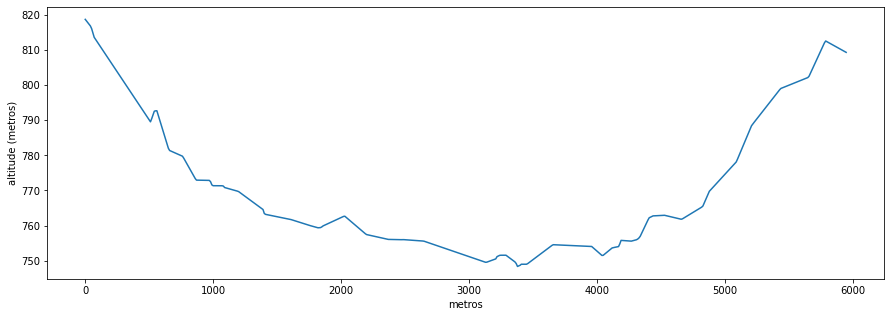

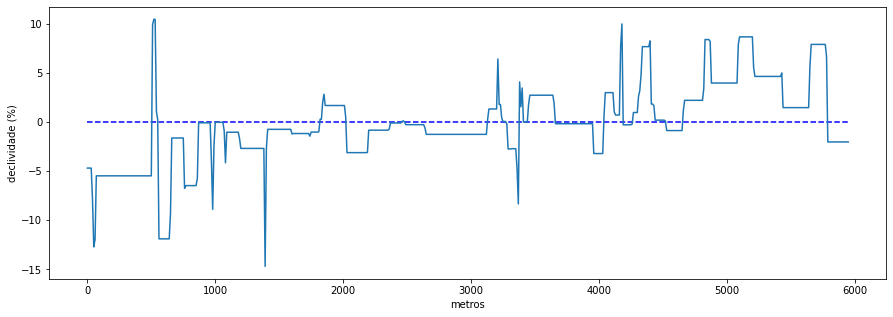

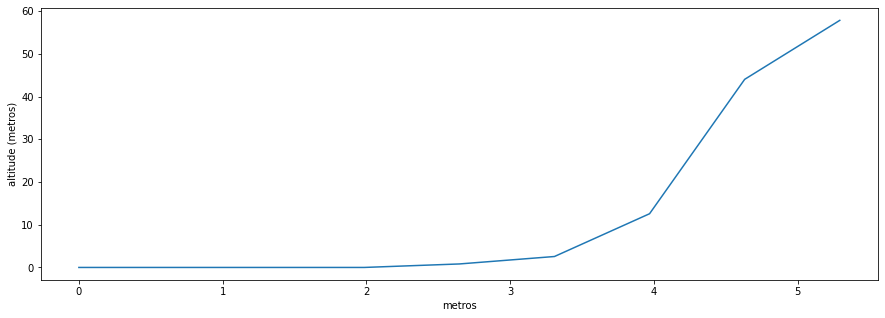

max inclinação:          10.46
min inclinação:          -14.7
declividade média:        -0.16
desvio padrao altitudes:  19.34
soma das elevações:       117.81542296732391


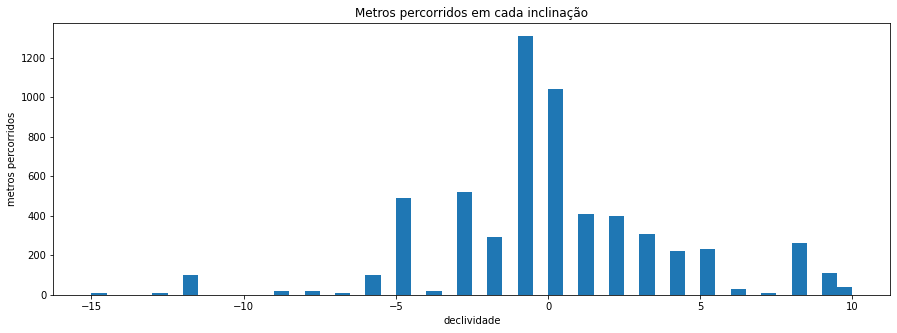

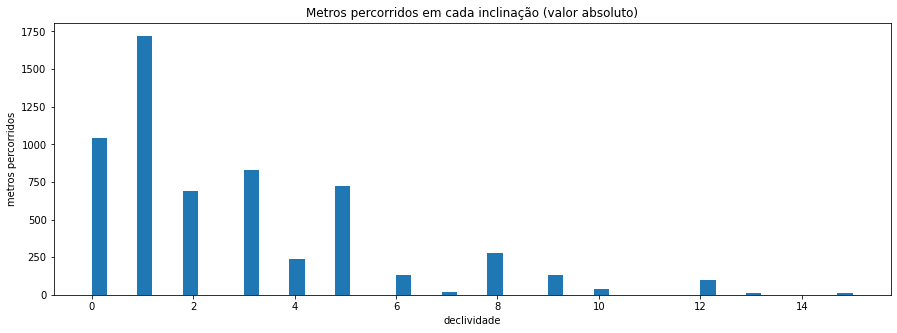

In [7]:
split_size = 10
r_ex = od_routes_sp.iloc[211] #968
r_ex_split = split_route(r_ex['geometry'], split_size)

heights = [line[0].coords[0][2] for line in r_ex_split]
slopes = [line[1] for line in r_ex_split]
lengths = [i * split_size for i in range(len(heights))]

s = split_route(r_ex['geometry'], r_ex.length * 10000)
l = [i * r_ex.length * 100/9 for i in range(9)]
elevs = [max(0, s[i][0].coords[-1][2] - s[i-1][0].coords[-1][2]) for i in range(1, len(s))]
for i in range(1, len(elevs)):
    elevs[i] += elevs[i-1]
    
plt.figure(figsize=(15,5))
plt.plot(lengths, heights, label='altitude')
plt.ylabel('altitude (metros)')
plt.xlabel('metros')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(lengths, [0]*len(lengths), 'b--', label='0')
plt.plot(lengths, slopes, label='declividade')
plt.ylabel('declividade (%)')
plt.xlabel('metros')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(l, elevs, label='altitude')
plt.ylabel('altitude (metros)')
plt.xlabel('metros')
plt.show()

print('max inclinação:         ', round(max(slopes), 2))
print('min inclinação:         ', round(min(slopes), 2))
print('declividade média:       ', round(sum(slopes)/len(slopes), 2))
print('desvio padrao altitudes: ', round(stdev(heights), 2))

# método do artigo que não encontrou relação
print('soma das elevações:      ', sum(elevs))

plt.figure(figsize=(15,5))
plt.hist(bins=50,x=[round(s) for s in slopes], weights = [split_size]*len(slopes))
plt.title('Metros percorridos em cada inclinação')
plt.xlabel('declividade')
plt.ylabel('metros percorridos')
plt.show()


plt.figure(figsize=(15,5))
plt.hist(bins=50,x=[round(abs(s)) for s in slopes], weights = [split_size]*len(slopes))
plt.title('Metros percorridos em cada inclinação (valor absoluto)')
plt.xlabel('declividade')
plt.ylabel('metros percorridos')
plt.show()

In [8]:
# calculating statistics
total_trips = sum(od_routes_sp['FE_VIA'])
eps = 1e-5

# return a list [value_10, value_20, ..., value_100] 
# where value_x is the value whose x% of the data is less than it  
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - eps:
            stats.append(i[value])
    return stats

stats_slope = []
for _, r in od_routes_sp.iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = floor(stretchs[0][1])
    for st in stretchs:
        s['meters_slope_' + str(floor(st[1]))] += st[0].length * 100000
        if current_slope == floor(st[1]):
            meters_in_slope += st[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = st[0].length * 100000
            current_slope = floor(st[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

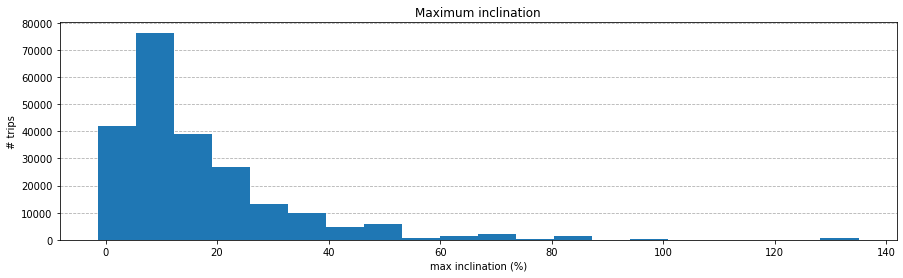

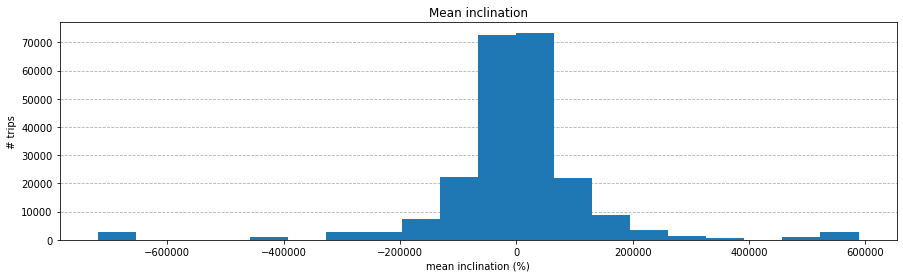

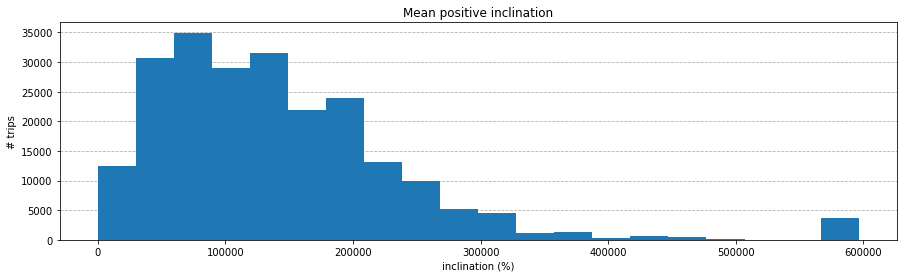

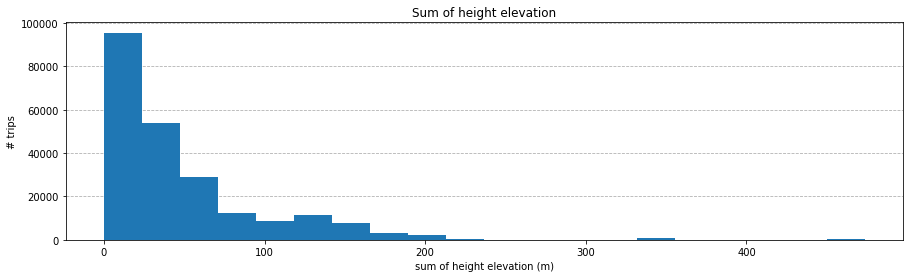

In [9]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['max'], weights = df_stats['fe_via'])
plt.title('Maximum inclination')
plt.xlabel('max inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean'], weights = df_stats['fe_via'])
plt.title('Mean inclination')
plt.xlabel('mean inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean_pos'], weights = df_stats['fe_via'])
plt.title('Mean positive inclination')
plt.xlabel('inclination (%)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['std_height'], weights = df_stats['fe_via'])
plt.title('Height Standard Deviation')
plt.xlabel('height standard deviation (m)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['sum_elevs'], weights = df_stats['fe_via'])
plt.title('Sum of height elevation')
plt.xlabel('sum of height elevation (m)')
plt.ylabel('# trips')
plt.show()

In [10]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

## Soma dos trechos percorridos em cada nível

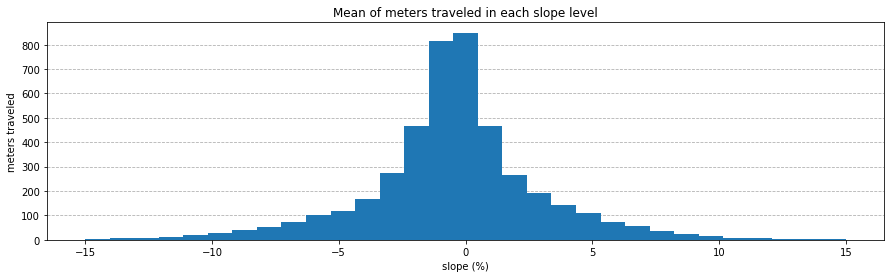

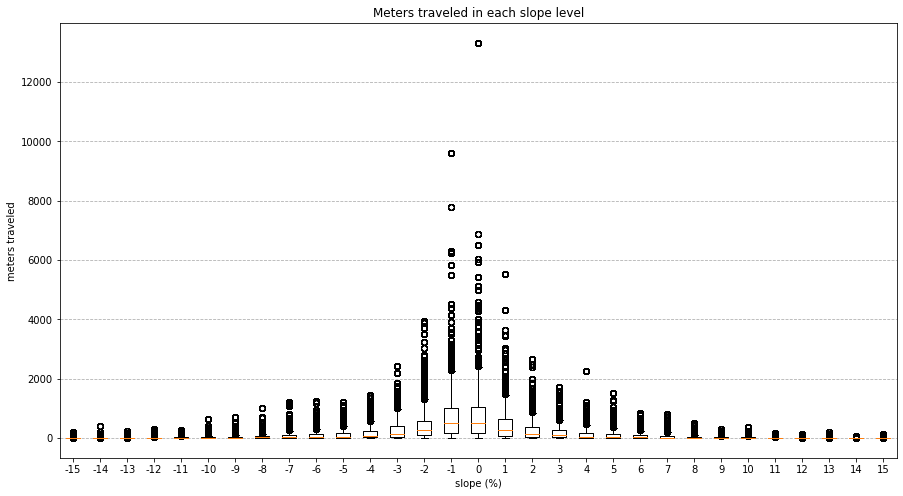

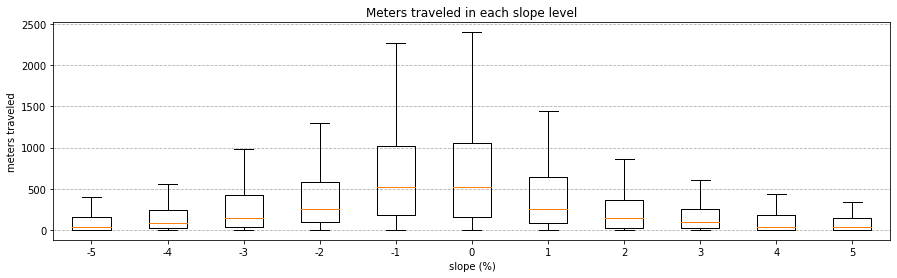

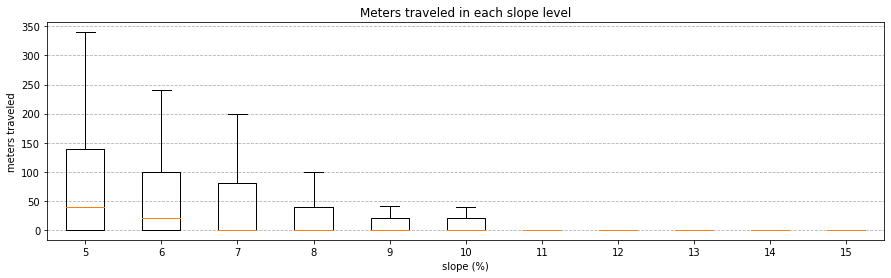

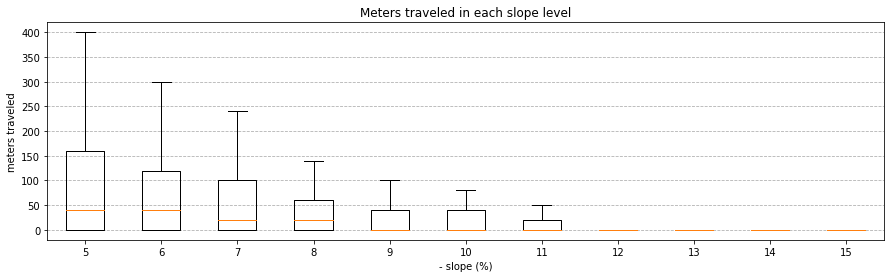

In [11]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

## Maior trecho percorrido em cada nível

In [12]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_max_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_down.append(meters_slope_i)

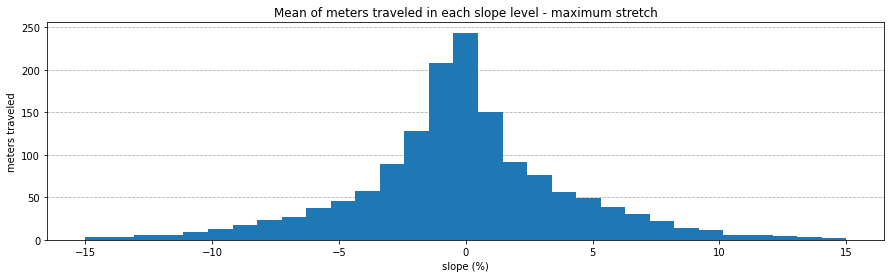

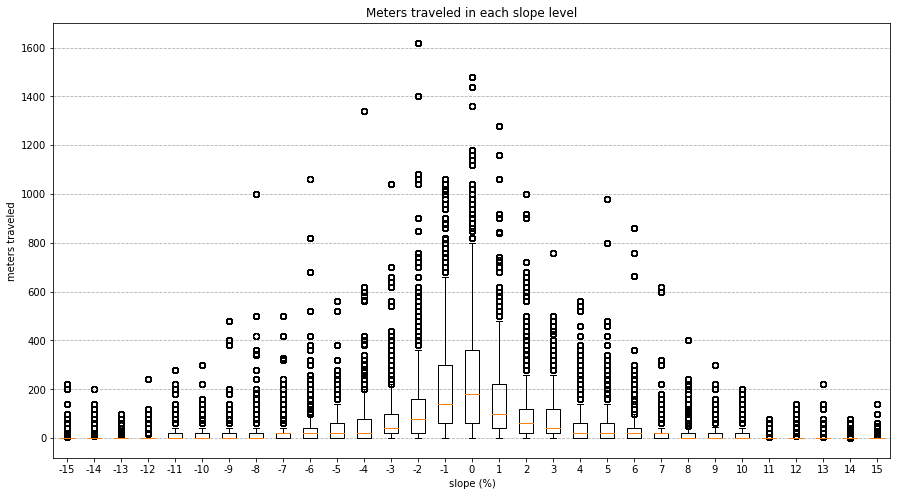

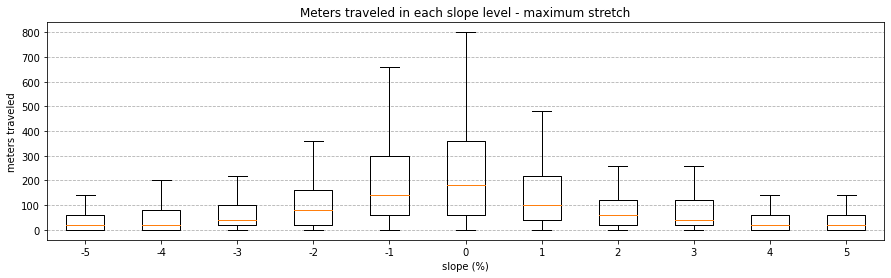

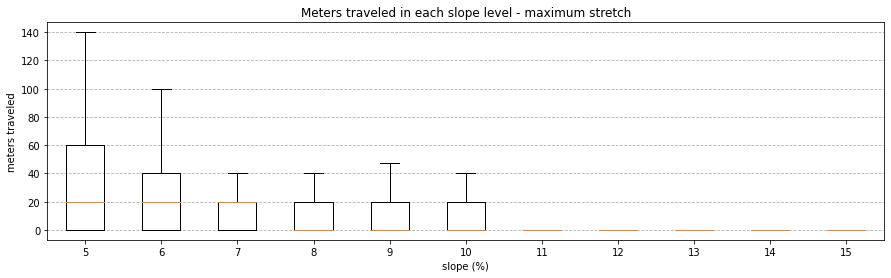

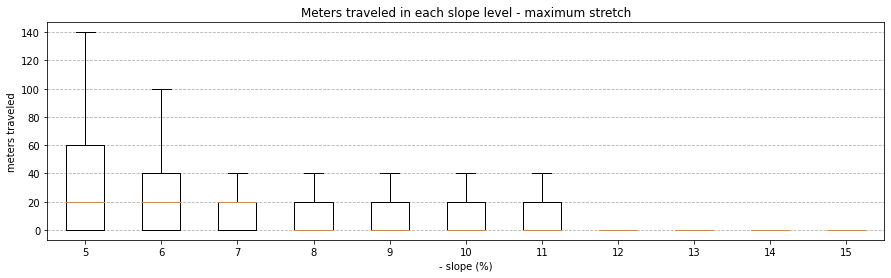

In [13]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level - maximum stretch')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level - maximum stretch')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level - maximum stretch')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level - maximum stretch')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

In [14]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []
stats_slope = []

od_routes_sp['HORA_SAIDA_INT'] = [int(h[:2] + h[3:5]) for h in od_routes_sp['HORA_SAIDA']]


for _, r in od_routes_sp.loc[od_routes_sp['HORA_SAIDA_INT'] >= 1400].iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = round(stretchs[0][1])
    for st in stretchs:
        s['meters_slope_' + str(round(st[1]))] += st[0].length * 100000
        if current_slope == round(st[1]):
            meters_in_slope += st[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = st[0].length * 100000
            current_slope = round(st[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

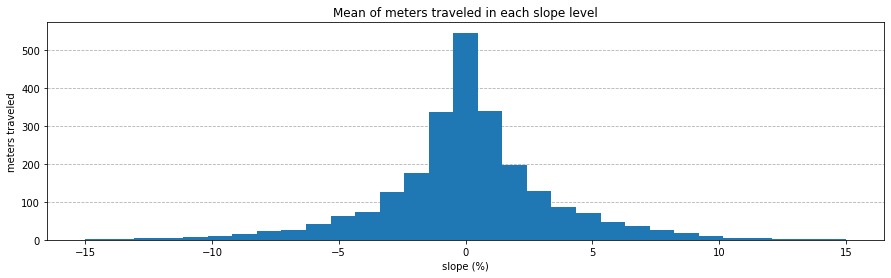

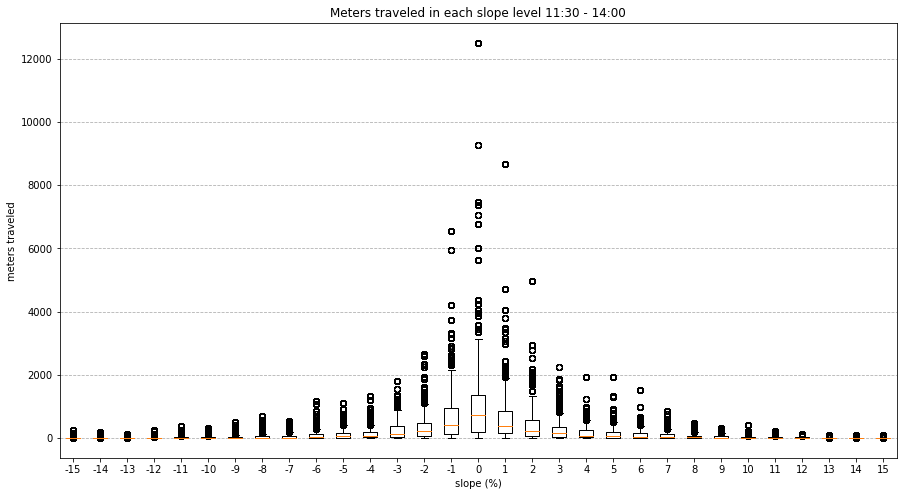

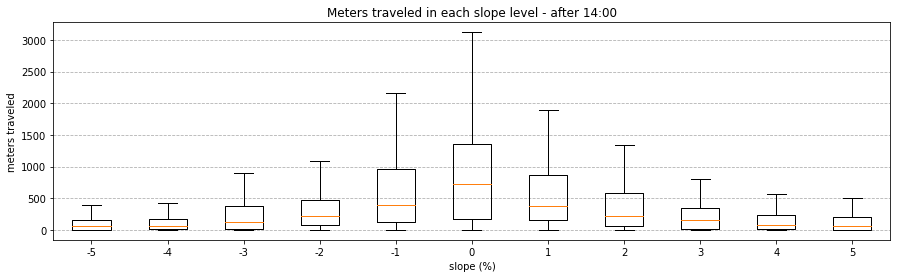

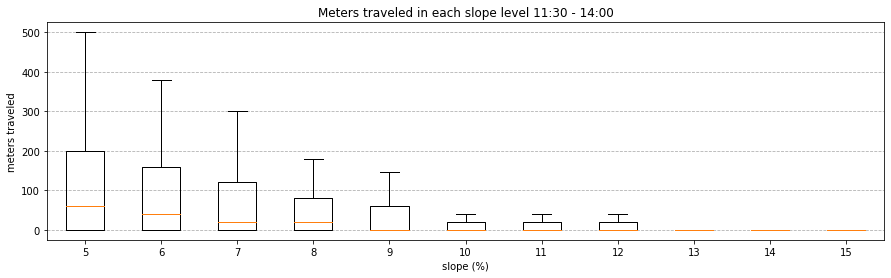

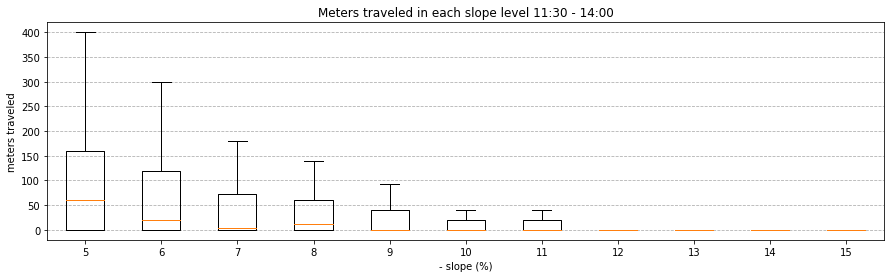

In [15]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level 11:30 - 14:00')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level - after 14:00')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level 11:30 - 14:00')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level 11:30 - 14:00')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()